===== TRAINING CSV INFO =====
CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1025
Rows that have all features = NaN: 20
TRAIN rows: 899
VAL   rows: 106
TEST  rows: 20
===== START TRAINING OR LOADING MODELS =====

=== Training/Loading LSTM model ===
[LSTM] Loaded existing model from ./best_LSTM_McDonal_V1.pt
LSTM => Completed test predictions

=== Training/Loading GRU model ===
[GRU] Loaded existing model from ./best_GRU_McDonal_V1.pt
GRU => Completed test predictions

=== Training/Loading RNN model ===
[RNN] Loaded existing model from ./best_RNN_McDonal_V1.pt
RNN => Completed test predictions

=== Training/Loading CNN model ===
[CNN] Loaded existing model from ./best_CNN_McDonal_V1.pt
CNN => Completed test predictions

=== Training/Loading Transformer model ===
[Transformer] Loaded existing model from ./best_Transformer_McDonal_V1.pt
Transformer => Completed test predictions

=== Training/Loading N-BEATS model ===
[N-BEATS] Loaded 

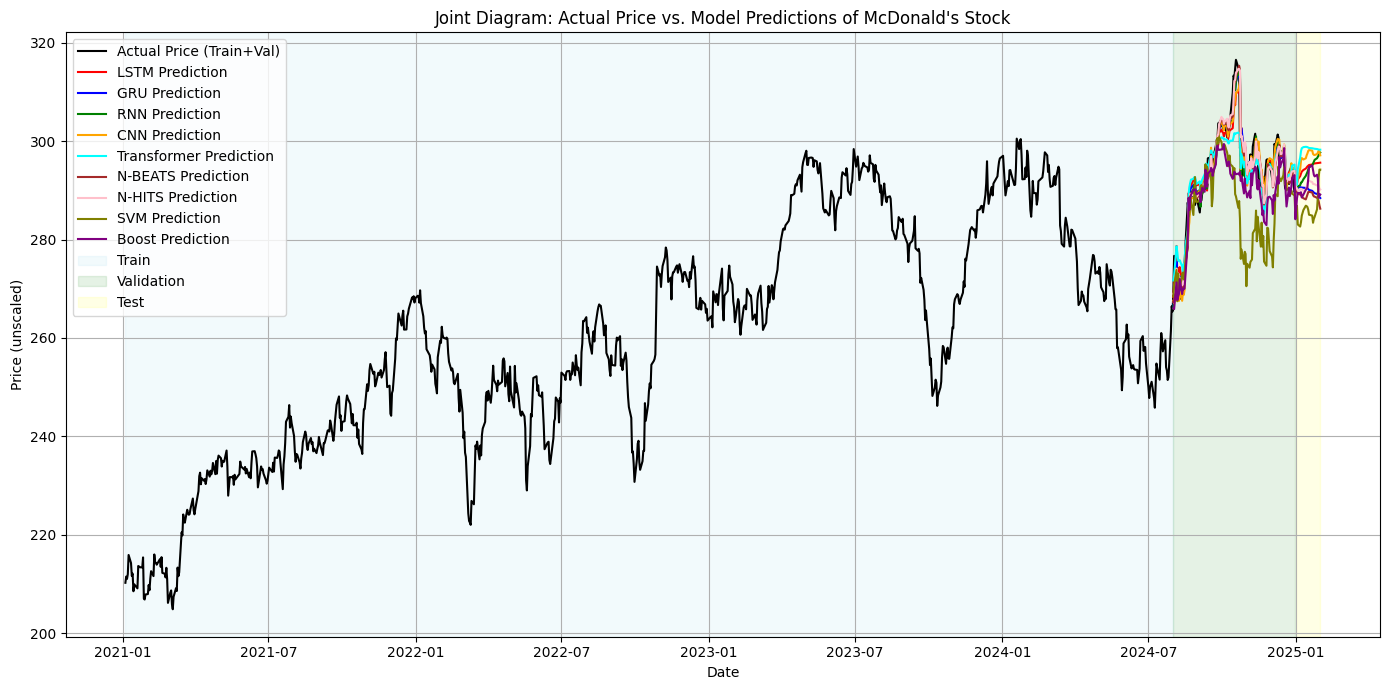

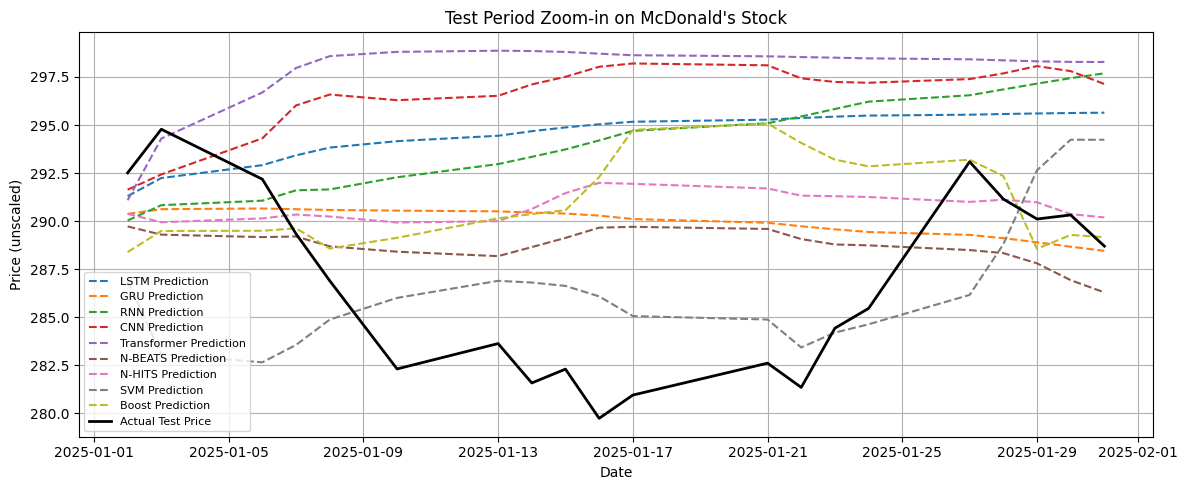


===== ROLLING FORECASTS (MOE) from 2025-01-01 to 2025-01-31 =====
   ForecastDate  Pred_Price_unscaled  Pred_Open_unscaled  Pred_High_unscaled  \
0    2025-01-01           288.389008          290.242615          291.973877   
1    2025-01-02           289.487549          289.181732          291.779816   
2    2025-01-03           289.497955          289.492096          291.487854   
3    2025-01-04           289.626770          288.591187          290.668213   
4    2025-01-05           288.573639          287.954132          289.095428   
5    2025-01-06           289.131653          288.241913          290.335571   
6    2025-01-07           290.146423          289.335022          290.602448   
7    2025-01-08           290.365387          290.856628          292.125702   
8    2025-01-09           290.570435          290.825867          291.598541   
9    2025-01-10           292.293671          290.800354          292.325470   
10   2025-01-11           294.745056          292.544

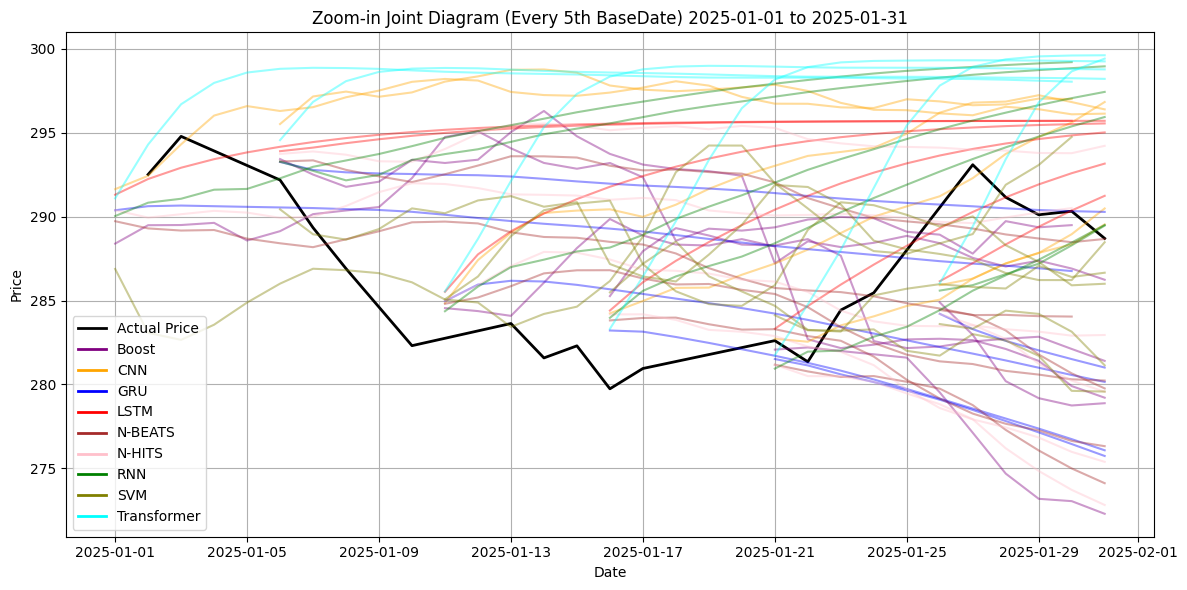


=== 2025-01-02 ===
  Model=CNN, Error=0.081, Conf=1.000
  Model=LSTM, Error=0.270, Conf=0.980
  Model=CNN, Error=0.875, Conf=0.915

=== 2025-01-03 ===
  Model=CNN, Error=0.474, Conf=1.000
  Model=Transformer, Error=0.485, Conf=0.999
  Model=Transformer, Error=0.924, Conf=0.961

=== 2025-01-06 ===
  Model=RNN, Error=0.020, Conf=1.000
  Model=N-HITS, Error=0.067, Conf=0.994
  Model=RNN, Error=0.102, Conf=0.989

=== 2025-01-07 ===
  Model=SVM, Error=0.080, Conf=1.000
  Model=Boost, Error=0.208, Conf=0.986
  Model=SVM, Error=0.393, Conf=0.967

=== 2025-01-08 ===
  Model=SVM, Error=0.006, Conf=1.000
  Model=SVM, Error=0.094, Conf=0.993
  Model=N-BEATS, Error=1.278, Conf=0.894

=== 2025-01-10 ===
  Model=SVM, Error=3.774, Conf=1.000
  Model=SVM, Error=4.320, Conf=0.957
  Model=Boost, Error=4.899, Conf=0.912

=== 2025-01-13 ===
  Model=SVM, Error=0.201, Conf=1.000
  Model=Boost, Error=0.455, Conf=0.983
  Model=RNN, Error=0.731, Conf=0.965

=== 2025-01-14 ===
  Model=Transformer, Error=1.656,

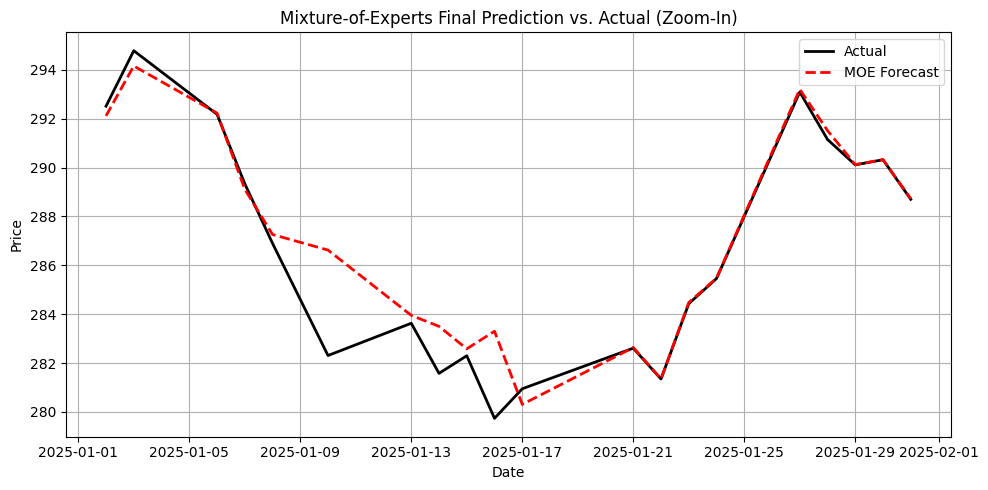


All done.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings (UserWarning, SettingWithCopyWarning, etc.)

# Pandas option to turn off chained assignment warnings
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import joblib
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# ============================================
# 1. Set random seeds
# ============================================
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ============================================
# Global hyperparameters
# ============================================
WINDOW_SIZE = 35
NUM_EPOCHS  = 800
features = ["Price", "Open", "High", "Low"]

# Filenames
csv_file_train    = "McDonald’s Stock Price History.csv"  # Partial / older data
csv_file_complete = "McDonald’s Stock Price History_Complete.csv"  # Full data
best_models_dir   = "."  # Directory for saved models

# ============================================
# 2. Load & Clean CSV (Training CSV)
# ============================================
df = pd.read_csv(csv_file_train)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("===== TRAINING CSV INFO =====")
print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

# Train/Val/Test cutoff dates
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-01")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

# ============================================
# 3. Fit MinMaxScaler on TRAIN only
# ============================================
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

joblib.dump(scaler, "scaler.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================
# 4. Create the training sequences
# ============================================
def make_sequences(df_subset, window=35):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

X_train_flat = X_train_all.reshape((X_train_all.shape[0], WINDOW_SIZE * 4))

# ============================================
# 5. Validation Utilities
# ============================================
import torch.nn.functional as F

def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=35):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]
            true_vals = df_work.loc[idx_current, features]
            true_vals = pd.to_numeric(true_vals, errors="coerce").astype(float).values
            if np.isnan(true_vals).any():
                continue
            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())
    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=35):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_4_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

def iterative_half_blind_validation_preds(model, df_all_scaled, val_start, val_end, window=35):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_idx = df_work.index[df_work["Date"] >= val_start]
    if len(val_idx) == 0:
        raise ValueError("No validation data available after val_start.")
    first_val_idx = val_idx[0]
    
    current_window = df_work.iloc[first_val_idx - window:first_val_idx][features].values
    preds = []
    val_dates = np.sort(df_work[df_work["Date"] >= val_start]["Date"].unique())
    
    model.eval()
    with torch.no_grad():
        for d in val_dates:
            if d > val_end:
                break
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
            
            actual_row = df_work[df_work["Date"] == d][features].values
            if actual_row.shape[0] == 0:
                continue
            actual = actual_row[0]
            current_window = np.vstack((current_window[1:], actual))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# ============================================
# 6. Define the base PyTorch model
# ============================================
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width
        
        if model_type == "CNN":
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)
        elif model_type == "N-BEATS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type in ["LSTM", "GRU", "RNN"]:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1, 0, 2)
            x = self.transformer_encoder(x)
            x = x[-1, :, :]
            out = self.fc(x)
        elif self.model_type in ["N-BEATS", "N-HITS"]:
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast += block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

# ============================================
# 7. Inverse transform helper
# ============================================
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

# ============================================
# 8. Training function for PyTorch
# ============================================
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_model(model_type="LSTM", num_epochs=800):
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)
    best_path = os.path.join(best_models_dir, f"best_{model_type}_McDonal_V1.pt")
    
    # If file exists, load
    if os.path.exists(best_path):
        model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"[{model_type}] Loaded existing model from {best_path}")
        return model

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=150)
    early_stopping = EarlyStopping(patience=150)
    
    best_val_loss = float("inf")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        
        val_loss = half_blind_validation_loss(model, df_scaled, val_start=train_cutoff, val_end=val_cutoff, window=WINDOW_SIZE)
        scheduler.step(val_loss)
        early_stopping(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)
        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break
        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")
    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

# ============================================
# 8B. Training function for sklearn
# ============================================
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        x_np = x.cpu().detach().numpy().reshape(1, -1)
        pred = self.model.predict(x_np)  # (1,4)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def train_model_sklearn(model_type, X_train_flat, y_train):
    best_path = os.path.join(best_models_dir, f"best_{model_type}_McDonal_V1.pkl")
    if os.path.exists(best_path):
        model = joblib.load(best_path)
        print(f"[{model_type}] Loaded existing model from {best_path}")
    else:
        if model_type == "SVM":
            base_model = SVR(kernel='rbf', C=10.0, epsilon=0.01)
        elif model_type == "GPR":
            from sklearn.gaussian_process.kernels import RBF
            base_model = GaussianProcessRegressor(kernel=RBF(length_scale=1.0), alpha=1e-2)
        elif model_type == "Boost":
            base_model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
        else:
            raise ValueError("Unsupported sklearn model type")
        multi_model = MultiOutputRegressor(base_model)
        multi_model.fit(X_train_flat, y_train)
        joblib.dump(multi_model, best_path)
        model = multi_model
    return SklearnWrapper(model)

# ============================================
# 9. Walk-forward test (Original style)
# ============================================
def walk_forward_test(model, df_all_scaled, test_start, window=35):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    preds = []
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled = model(X_input).cpu().numpy()[0]
            df_work.loc[idx_current, features] = y_pred_4_scaled
            preds.append((d, *y_pred_4_scaled))
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# ============================================
# 10. Evaluate & Plot
# ============================================
def evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff):
    df_real = df_scaled[["Date", "Price", "Open", "High", "Low"]].copy()
    df_real.sort_values("Date", inplace=True)
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:, 0]
    
    # Plot 1: Joint diagram
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")
    
    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)

    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    for model_name, info in results_dict.items():
        val_pred_df = info["val_pred_df"]
        test_pred_df = info["test_pred_df"]
        frames = []
        if val_pred_df is not None:
            frames.append(val_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if test_pred_df is not None:
            frames.append(test_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if not frames:
            continue
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df = combined_df[["Date", f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)
        merged_df = pd.merge(merged_df, combined_df, on="Date", how="left")

    for model_name in results_dict.keys():
        col = f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(merged_df["Date"], merged_df[col],
                     color=color_map.get(model_name, "gray"),
                     linestyle="-",
                     label=f"{model_name} Prediction")

    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")
    plt.title("Joint Diagram: Actual Price vs. Model Predictions of McDonald's Stock")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Test Period Zoom-in
    df_test_zoom = merged_df[merged_df["Date"] >= test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        for model_name in results_dict.keys():
            col = f"Pred_{model_name}"
            if col in df_test_zoom.columns:
                plt.plot(df_test_zoom["Date"], df_test_zoom[col],
                         linestyle="--", label=f"{model_name} Prediction")
        # Overlay actual test prices from complete CSV
        df_complete_test = pd.read_csv(csv_file_complete)
        df_complete_test["Date"] = pd.to_datetime(df_complete_test["Date"])
        df_complete_test.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
        df_complete_test.sort_values("Date", inplace=True)
        df_test_actual = df_complete_test[df_complete_test["Date"] >= test_cutoff].copy()
        plt.plot(df_test_actual["Date"], df_test_actual["Price"],
                 color='black', linewidth=2, label='Actual Test Price')

        plt.title("Test Period Zoom-in on McDonald's Stock")
        plt.xlabel("Date")
        plt.ylabel("Price (unscaled)")
        plt.legend(prop={'size':8})
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ============================================
# 11A. Plot single joint diagram (every 5th base date, zoom-in)
# ============================================
def plot_joint_5day_forecasts_zoom_in(
    final_rolling_fcst,
    df_actual,
    start_date_plot=pd.to_datetime("2025-01-01"),
    end_date_plot=pd.to_datetime("2025-01-31"),
    base_date_freq=5
):
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    df_actual_plot = df_actual[
        (df_actual["Date"] >= start_date_plot) & (df_actual["Date"] <= end_date_plot)
    ].copy()

    unique_base_dates = sorted(final_rolling_fcst["BaseDate"].unique())
    chosen_base_dates = [bd for i, bd in enumerate(unique_base_dates) if i % base_date_freq == 0]

    plt.figure(figsize=(12,6))
    plt.plot(df_actual_plot["Date"], df_actual_plot["Price"],
             color="black", linewidth=2, label="Actual Price")

    models = final_rolling_fcst["Model"].unique()
    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"] == m].copy()
        c = color_map.get(m, "gray")
        for bd in chosen_base_dates:
            df_bd = df_m[df_m["BaseDate"] == bd].copy()
            df_bd = df_bd[
                (df_bd["ForecastDate"] >= start_date_plot) &
                (df_bd["ForecastDate"] <= end_date_plot)
            ]
            if len(df_bd) < 1:
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"],
                     color=c, alpha=0.4, linewidth=1.5)

    from matplotlib.lines import Line2D
    legend_elems = [Line2D([0],[0], color="black", lw=2, label="Actual Price")]
    for m in models:
        legend_elems.append(Line2D([0],[0], color=color_map.get(m,"gray"), lw=2, label=m))
    plt.legend(handles=legend_elems, loc="best")

    plt.title(f"Zoom-in Joint Diagram (Every 5th BaseDate) {start_date_plot.date()} to {end_date_plot.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ============================================
# 11B. Compute errors & confidence, print top 3 models
# ============================================
def compute_confidences_and_top3(final_rolling_fcst, df_actual):
    """
    Merges final_rolling_fcst with the actual Price on 'ForecastDate',
    then computes absolute error, normalizes confidence among *all models*
    for that date. Prints top 3 each day. Returns a DF with:
      [ForecastDate, Model, Pred_Price_unscaled, AbsError, Confidence, ActualPrice].
    """
    df_pred = final_rolling_fcst[["ForecastDate", "Model", "Pred_Price_unscaled"]].copy()
    df_actual_ren = df_actual.rename(columns={"Date": "ForecastDate", "Price": "ActualPrice"})
    df_merged = pd.merge(df_pred, df_actual_ren[["ForecastDate", "ActualPrice"]], on="ForecastDate", how="inner")
    df_merged.dropna(subset=["ActualPrice", "Pred_Price_unscaled"], inplace=True)

    df_merged["AbsError"] = (df_merged["Pred_Price_unscaled"] - df_merged["ActualPrice"]).abs()

    # min-max approach => bigger error => lower confidence
    def compute_confidence_group(grp):
        err_min = grp["AbsError"].min()
        err_max = grp["AbsError"].max()
        if abs(err_max - err_min) < 1e-9:
            grp["Confidence"] = 1.0
        else:
            grp["Confidence"] = 1.0 - ((grp["AbsError"] - err_min) / (err_max - err_min))
        return grp

    df_out = df_merged.groupby("ForecastDate", group_keys=False).apply(compute_confidence_group)

    # Print top 3
    unique_days = sorted(df_out["ForecastDate"].unique())
    for d in unique_days:
        day_grp = df_out[df_out["ForecastDate"] == d].copy()
        day_grp.sort_values("AbsError", inplace=True)
        top_n = day_grp.head(3)
        print(f"\n=== {d.date()} ===")
        for _, row in top_n.iterrows():
            print(f"  Model={row['Model']}, Error={row['AbsError']:.3f}, Conf={row['Confidence']:.3f}")

    return df_out[["ForecastDate", "Model", "Pred_Price_unscaled", "AbsError", "Confidence", "ActualPrice"]].copy()

# ============================================
# 11C. Produce Mixture-of-Experts Forecast
# ============================================
def produce_moe_predictions(df_conf):
    """
    For each ForecastDate, pick top 3 models by Confidence (not error),
    re-normalize so sum of those 3 confidences = 1, produce final MOE forecast.
    Returns a DF: [ForecastDate, MOE_Pred, ActualPrice, MOE_AbsError].
    """
    grouped = []
    # We'll also keep track of best-model-of-day for logging
    best_model_records = []

    for fdate, grp in df_conf.groupby("ForecastDate"):
        # Sort by Confidence descending
        grp_sorted = grp.sort_values("Confidence", ascending=False).reset_index(drop=True)
        top3 = grp_sorted.head(3).copy()
        # Sum of top3 confidences
        sum_conf = top3["Confidence"].sum()

        # Re-normalize so top3 sums to 1
        if abs(sum_conf) < 1e-9:
            # fallback: uniform or do something else
            top3["NormConf"] = 1.0 / 3.0
        else:
            top3["NormConf"] = top3["Confidence"] / sum_conf
        
        # Weighted sum
        moe_pred = (top3["NormConf"] * top3["Pred_Price_unscaled"]).sum()
        actual_price = grp["ActualPrice"].iloc[0]
        moe_abs_err = abs(moe_pred - actual_price)

        # The single best model is the #1 row in grp_sorted
        best_model = grp_sorted.loc[0, "Model"]
        best_model_conf = grp_sorted.loc[0, "Confidence"]
        best_model_err  = grp_sorted.loc[0, "AbsError"]

        best_model_records.append({
            "ForecastDate": fdate,
            "BestModel": best_model,
            "BestModelConf": best_model_conf,
            "BestModelError": best_model_err
        })

        grouped.append({
            "ForecastDate": fdate,
            "MOE_Pred": moe_pred,
            "ActualPrice": actual_price,
            "MOE_AbsError": moe_abs_err
        })

    df_moe = pd.DataFrame(grouped)
    df_best = pd.DataFrame(best_model_records)

    print("\n===== Best Model of the Day (highest confidence) =====")
    for i, row in df_best.sort_values("ForecastDate").iterrows():
        d = row["ForecastDate"]
        bm = row["BestModel"]
        bc = row["BestModelConf"]
        be = row["BestModelError"]
        print(f"{d.date()}: {bm} (Conf={bc:.3f}, Error={be:.3f})")

    return df_moe

# ============================================
# 11D. Plot Final MoE curve vs Actual
# ============================================
def plot_moe_vs_actual(df_moe, start_date=pd.to_datetime("2025-01-01"), end_date=pd.to_datetime("2025-01-31")):
    """
    Plots a single curve: MOE_Pred vs. ActualPrice for the test period.
    """
    df_plot = df_moe[(df_moe["ForecastDate"] >= start_date) & (df_moe["ForecastDate"] <= end_date)].copy()
    if df_plot.empty:
        print("No MOE data in the specified date range.")
        return

    plt.figure(figsize=(10,5))
    plt.plot(df_plot["ForecastDate"], df_plot["ActualPrice"], color="black", linewidth=2, label="Actual")
    plt.plot(df_plot["ForecastDate"], df_plot["MOE_Pred"], color="red", linewidth=2, linestyle="--", label="MOE Forecast")
    plt.title("Mixture-of-Experts Final Prediction vs. Actual (Zoom-In)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================
# 12. MAIN
# ============================================
if __name__ == "__main__":
    # 1) Train/Load models
    all_model_types = ["LSTM", "GRU", "RNN", "CNN", "Transformer", "N-BEATS", "N-HITS", "SVM", "Boost"]
    results_dict = {}

    print("===== START TRAINING OR LOADING MODELS =====")
    for mt in all_model_types:
        print(f"\n=== Training/Loading {mt} model ===")
        if mt in ["SVM", "GPR", "Boost"]:
            model = train_model_sklearn(mt, X_train_flat, y_train_all)
        else:
            model = train_model(mt, num_epochs=NUM_EPOCHS)

        # Validation predictions
        if mt in ["SVM", "Transformer", "Boost"]:
            val_pred_df = iterative_half_blind_validation_preds(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )
        else:
            val_pred_df = half_blind_validation_preds_df(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )

        # Test predictions
        test_pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=WINDOW_SIZE
        )

        results_dict[mt] = {
            "val_pred_df": val_pred_df,
            "test_pred_df": test_pred_df
        }
        print(f"{mt} => Completed test predictions")

    # 2) Evaluate & Plot the original approach
    evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff)

    # 3) Rolling 30-day Forecast from 2025-01-01 to 2025-01-31
    df_complete_all = pd.read_csv(csv_file_complete)
    df_complete_all["Date"] = pd.to_datetime(df_complete_all["Date"], errors="coerce")
    df_complete_all.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    for col in features:
        df_complete_all[col] = (
            df_complete_all[col].astype(str)
            .str.replace(",", "", regex=True)
            .astype(float)
        )
    df_complete_all.sort_values("Date", inplace=True)
    df_complete_all.reset_index(drop=True, inplace=True)

    # Re-build dictionary for each model
    models_dict = {}
    for mt in all_model_types:
        if mt in ["SVM", "Boost", "GPR"]:
            pkl_path = os.path.join(best_models_dir, f"best_{mt}_McDonal_V1.pkl")
            if not os.path.exists(pkl_path):
                print(f"Warning: {pkl_path} not found. Skipping.")
                continue
            loaded_model = joblib.load(pkl_path)
            models_dict[mt] = SklearnWrapper(loaded_model)
        else:
            pt_path = os.path.join(best_models_dir, f"best_{mt}_McDonal_V1.pt")
            if not os.path.exists(pt_path):
                print(f"Warning: {pt_path} not found. Skipping.")
                continue
            new_model = BaseModel(model_type=mt, window_width=WINDOW_SIZE).to(device)
            new_model.load_state_dict(torch.load(pt_path, map_location=device))
            new_model.eval()
            models_dict[mt] = new_model

    def get_latest_window(actual_df, current_date, window=WINDOW_SIZE):
        mask = actual_df["Date"] < current_date
        df_subset = actual_df.loc[mask].copy()
        df_subset.sort_values("Date", inplace=True)
        if len(df_subset) < window:
            return None
        df_window = df_subset.iloc[-window:].copy()
        df_window[features] = df_window[features].fillna(method="ffill").fillna(method="bfill")
        arr_window = scaler.transform(df_window[features])
        return arr_window

    def forecast_30_days_from_date(model, df_actual, start_date, window=WINDOW_SIZE, horizon=30, device=device):
        arr_window = get_latest_window(df_actual, start_date, window=window)
        if arr_window is None:
            return pd.DataFrame()

        forecast_records = []
        rolling_buffer = np.copy(arr_window)
        current_date = pd.to_datetime(start_date)
        for i in range(horizon):
            X_input = torch.tensor(rolling_buffer, dtype=torch.float).unsqueeze(0).to(device)
            with torch.no_grad():
                pred_4_scaled = model(X_input).cpu().numpy()[0]
            pred_4_unscaled = scaler.inverse_transform(pred_4_scaled.reshape(1, -1))[0]
            forecast_day = current_date + pd.Timedelta(days=i)
            forecast_records.append({
                "ForecastDate": forecast_day,
                "Pred_Price_unscaled": pred_4_unscaled[0],
                "Pred_Open_unscaled":  pred_4_unscaled[1],
                "Pred_High_unscaled":  pred_4_unscaled[2],
                "Pred_Low_unscaled":   pred_4_unscaled[3],
            })
            # shift
            new_row_scaled = pred_4_scaled.reshape(1, -1)
            rolling_buffer = np.vstack((rolling_buffer[1:], new_row_scaled))
        return pd.DataFrame(forecast_records)

    def rolling_moe_forecasts(models_dict, df_actual, start_day="2025-01-01", end_day="2025-01-31",
                              window_size=WINDOW_SIZE, horizon=30, device=device):
        df_actual["Date"] = pd.to_datetime(df_actual["Date"])
        start_day = pd.to_datetime(start_day)
        end_day   = pd.to_datetime(end_day)
        all_days = pd.date_range(start=start_day, end=end_day, freq="D")
        results_list = []

        for base_date in all_days:
            for model_name, model_obj in models_dict.items():
                df_fcst = forecast_30_days_from_date(
                    model=model_obj,
                    df_actual=df_actual,
                    start_date=base_date,
                    window=window_size,
                    horizon=horizon,
                    device=device
                )
                if df_fcst.empty:
                    continue
                df_fcst["BaseDate"] = base_date
                df_fcst["Model"] = model_name
                results_list.append(df_fcst)

        df_all_forecasts = pd.concat(results_list, ignore_index=True)
        df_all_forecasts.sort_values(["Model", "BaseDate", "ForecastDate"], inplace=True)
        df_all_forecasts.reset_index(drop=True, inplace=True)
        return df_all_forecasts

    # Generate final rolling forecasts for Jan 1 to Jan 31
    final_rolling_fcst = rolling_moe_forecasts(
        models_dict=models_dict,
        df_actual=df_complete_all,
        start_day="2025-01-01",
        end_day="2025-01-31",
        window_size=WINDOW_SIZE,
        horizon=30,
        device=device
    )

    print("\n===== ROLLING FORECASTS (MOE) from 2025-01-01 to 2025-01-31 =====")
    print(final_rolling_fcst.head(50))
    print("Total rows in final_rolling_fcst:", len(final_rolling_fcst))

    # A) Single Joint Diagram (for every 5th base date)
    plot_joint_5day_forecasts_zoom_in(
        final_rolling_fcst=final_rolling_fcst,
        df_actual=df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-01-31"),
        base_date_freq=5
    )

    # B) Compute daily forecast errors & top 3
    df_conf = compute_confidences_and_top3(final_rolling_fcst, df_complete_all)

    # C) Produce mixture-of-experts final predictions, with re-normalized top 3 confidences
    df_moe = produce_moe_predictions(df_conf)
    print("\n===== MOE DataFrame (head) =====")
    print(df_moe.head(20))

    # D) Plot final MoE curve vs. Actual
    plot_moe_vs_actual(df_moe, start_date=pd.to_datetime("2025-01-01"), end_date=pd.to_datetime("2025-01-31"))

    print("\nAll done.")


===== TRAINING CSV INFO =====
CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1025
Rows that have all features = NaN: 20
TRAIN rows: 899
VAL   rows: 106
TEST  rows: 20
===== START TRAINING OR LOADING MODELS =====

=== Training/Loading LSTM model ===
[LSTM] Loaded existing model from ./best_LSTM_McDonal_V1.pt
LSTM => Completed test predictions

=== Training/Loading GRU model ===
[GRU] Loaded existing model from ./best_GRU_McDonal_V1.pt
GRU => Completed test predictions

=== Training/Loading RNN model ===
[RNN] Loaded existing model from ./best_RNN_McDonal_V1.pt
RNN => Completed test predictions

=== Training/Loading CNN model ===
[CNN] Loaded existing model from ./best_CNN_McDonal_V1.pt
CNN => Completed test predictions

=== Training/Loading Transformer model ===
[Transformer] Loaded existing model from ./best_Transformer_McDonal_V1.pt


/home/yuzhe/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer => Completed test predictions

=== Training/Loading N-BEATS model ===
[N-BEATS] Loaded existing model from ./best_N-BEATS_McDonal_V1.pt
N-BEATS => Completed test predictions

=== Training/Loading N-HITS model ===
[N-HITS] Loaded existing model from ./best_N-HITS_McDonal_V1.pt
N-HITS => Completed test predictions

=== Training/Loading SVM model ===
[SVM] Loaded existing model from ./best_SVM_McDonal_V1.pkl
SVM => Completed test predictions

=== Training/Loading Boost model ===
[Boost] Loaded existing model from ./best_Boost_McDonal_V1.pkl
Boost => Completed test predictions


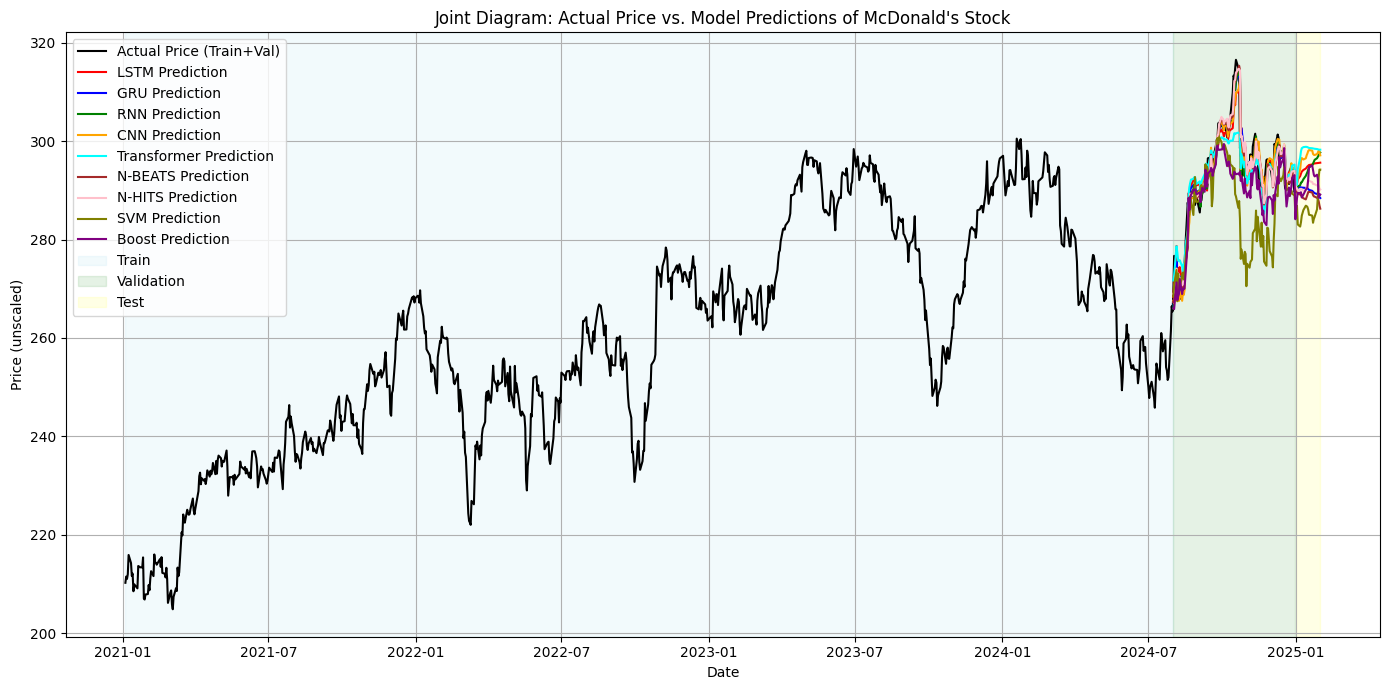

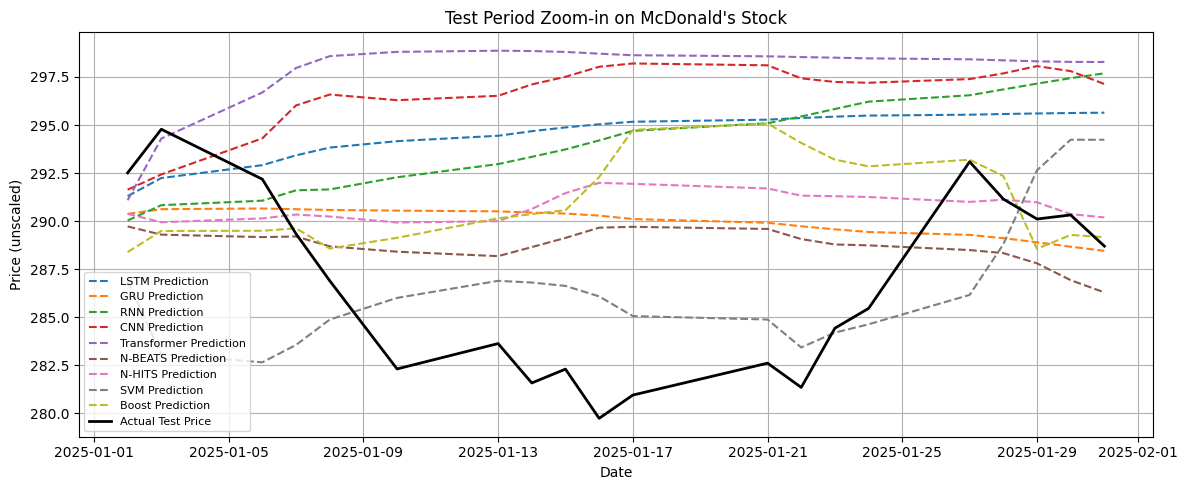

/tmp/ipykernel_646386/416538541.py:805: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load(pt_path, map_location=device))
/home/yuzhe/.local/


===== ROLLING FORECASTS (MOE) from 2025-01-01 to 2025-01-31 =====
   ForecastDate  Pred_Price_unscaled  Pred_Open_unscaled  Pred_High_unscaled  \
0    2025-01-01           288.389008          290.242615          291.973877   
1    2025-01-02           289.487549          289.181732          291.779816   
2    2025-01-03           289.497955          289.492096          291.487854   
3    2025-01-04           289.626770          288.591187          290.668213   
4    2025-01-05           288.573639          287.954132          289.095428   
5    2025-01-06           289.131653          288.241913          290.335571   
6    2025-01-07           290.146423          289.335022          290.602448   
7    2025-01-08           290.365387          290.856628          292.125702   
8    2025-01-09           290.570435          290.825867          291.598541   
9    2025-01-10           292.293671          290.800354          292.325470   
10   2025-01-11           294.745056          292.544

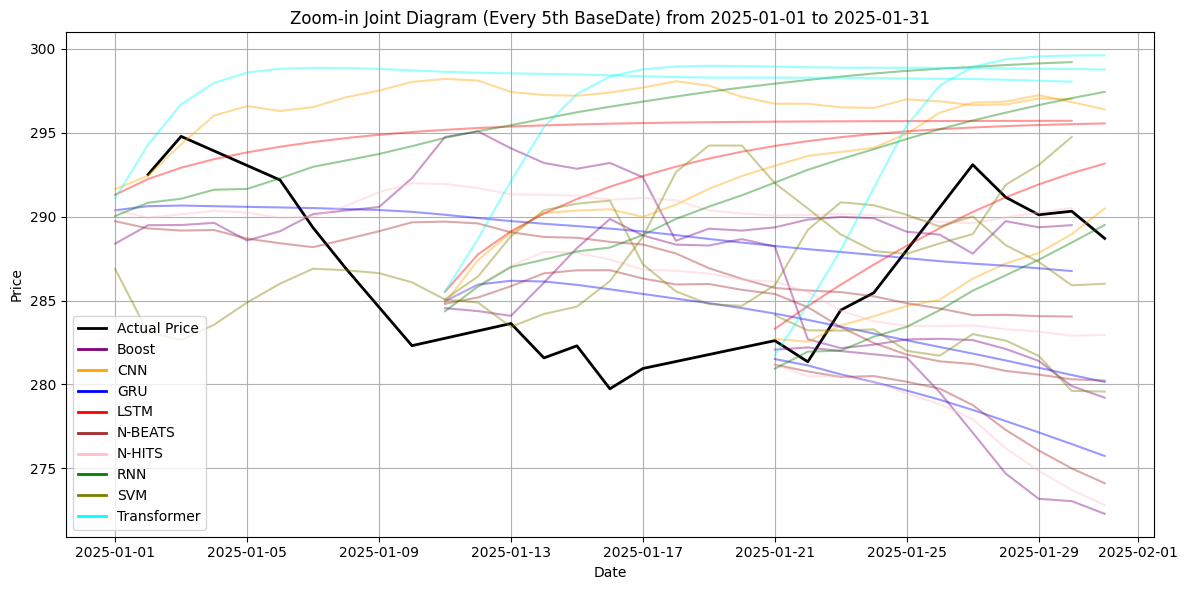


=== 2025-01-02 ===
  Model=CNN, Error=0.081, Conf=1.000
  Model=LSTM, Error=0.270, Conf=0.980
  Model=CNN, Error=0.875, Conf=0.915

=== 2025-01-03 ===
  Model=CNN, Error=0.474, Conf=1.000
  Model=Transformer, Error=0.485, Conf=0.999
  Model=Transformer, Error=0.924, Conf=0.961

=== 2025-01-06 ===
  Model=RNN, Error=0.020, Conf=1.000
  Model=N-HITS, Error=0.067, Conf=0.994
  Model=RNN, Error=0.102, Conf=0.989

=== 2025-01-07 ===
  Model=SVM, Error=0.080, Conf=1.000
  Model=Boost, Error=0.208, Conf=0.986
  Model=SVM, Error=0.393, Conf=0.967

=== 2025-01-08 ===
  Model=SVM, Error=0.006, Conf=1.000
  Model=SVM, Error=0.094, Conf=0.993
  Model=N-BEATS, Error=1.278, Conf=0.894

=== 2025-01-10 ===
  Model=SVM, Error=3.774, Conf=1.000
  Model=SVM, Error=4.320, Conf=0.957
  Model=Boost, Error=4.899, Conf=0.912

=== 2025-01-13 ===
  Model=SVM, Error=0.201, Conf=1.000
  Model=Boost, Error=0.455, Conf=0.983
  Model=RNN, Error=0.731, Conf=0.965

=== 2025-01-14 ===
  Model=Transformer, Error=1.656,

/tmp/ipykernel_646386/416538541.py:708: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_out = df_merged.groupby("ForecastDate", group_keys=False).apply(compute_confidence_group)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib

# Additional imports for sklearn-based models:
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# ============================================
# 1. Set random seeds
# ============================================
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ============================================
# Global hyperparameters
# ============================================
WINDOW_SIZE = 35
NUM_EPOCHS  = 800
features = ["Price", "Open", "High", "Low"]

# Filenames (adjust as needed)
csv_file_train = "McDonald’s Stock Price History.csv"             # Partial / older data
csv_file_complete = "McDonald’s Stock Price History_Complete.csv"  # Full data (incl. future)
best_models_dir = "."  # Directory for saved models (change if needed)

# ============================================
# 2. Load & Clean CSV (Training CSV)
# ============================================
df = pd.read_csv(csv_file_train)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("===== TRAINING CSV INFO =====")
print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

# Train/Val/Test cutoff dates
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-01")  # We'll do day-by-day from Jan 1 to Jan 31

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

# ============================================
# 3. Fit MinMaxScaler on TRAIN only
# ============================================
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

# Optionally, save the scaler if needed
joblib.dump(scaler, "scaler.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================
# 4. Create the training sequences
# ============================================
def make_sequences(df_subset, window=35):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Flatten for sklearn
X_train_flat = X_train_all.reshape((X_train_all.shape[0], WINDOW_SIZE * 4))

# ============================================
# 5. Validation Utilities
# ============================================
def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=35):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]
            true_vals = df_work.loc[idx_current, features]
            true_vals = pd.to_numeric(true_vals, errors="coerce").astype(float).values
            if np.isnan(true_vals).any():
                continue
            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())
    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=35):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_4_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

def iterative_half_blind_validation_preds(model, df_all_scaled, val_start, val_end, window=35):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_idx = df_work.index[df_work["Date"] >= val_start]
    if len(val_idx) == 0:
        raise ValueError("No validation data available after val_start.")
    first_val_idx = val_idx[0]
    
    current_window = df_work.iloc[first_val_idx - window:first_val_idx][features].values
    preds = []
    val_dates = np.sort(df_work[df_work["Date"] >= val_start]["Date"].unique())
    
    model.eval()
    with torch.no_grad():
        for d in val_dates:
            if d > val_end:
                break
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
            
            # Reveal actual for day d
            actual_row = df_work[df_work["Date"] == d][features].values
            if actual_row.shape[0] == 0:
                continue
            actual = actual_row[0]
            current_window = np.vstack((current_window[1:], actual))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# ============================================
# 6. Define the base PyTorch model
# ============================================
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width
        
        if model_type == "CNN":
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)
        elif model_type == "N-BEATS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type in ["LSTM", "GRU", "RNN"]:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1, 0, 2)
            x = self.transformer_encoder(x)
            x = x[-1, :, :]
            out = self.fc(x)
        elif self.model_type in ["N-BEATS", "N-HITS"]:
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

# ============================================
# Early Stopping
# ============================================
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ============================================
# 7. Inverse transform helper
# ============================================
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

# ============================================
# 8. Training function for PyTorch
# ============================================
def train_model(model_type="LSTM", num_epochs=800):
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)
    best_path = os.path.join(best_models_dir, f"best_{model_type}_McDonal_V1.pt")
    
    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"[{model_type}] Loaded existing model from {best_path}")
        return model

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=150)
    early_stopping = EarlyStopping(patience=150)
    
    best_val_loss = float("inf")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        
        val_loss = half_blind_validation_loss(model, df_scaled, val_start=train_cutoff, val_end=val_cutoff, window=WINDOW_SIZE)
        scheduler.step(val_loss)
        early_stopping(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)
        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break
        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")
    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

# ============================================
# 8B. Training function for sklearn
# ============================================
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        x_np = x.cpu().detach().numpy().reshape(1, -1)
        pred = self.model.predict(x_np)  # shape: (1,4)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def train_model_sklearn(model_type, X_train_flat, y_train):
    best_path = os.path.join(best_models_dir, f"best_{model_type}_McDonal_V1.pkl")
    if os.path.exists(best_path):
        model = joblib.load(best_path)
        print(f"[{model_type}] Loaded existing model from {best_path}")
    else:
        if model_type == "SVM":
            base_model = SVR(kernel='rbf', C=10.0, epsilon=0.01)
        elif model_type == "GPR":
            from sklearn.gaussian_process.kernels import RBF
            kernel = RBF(length_scale=1.0)
            base_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
        elif model_type == "Boost":
            base_model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
        else:
            raise ValueError("Unsupported sklearn model type")
        multi_model = MultiOutputRegressor(base_model)
        multi_model.fit(X_train_flat, y_train)
        joblib.dump(multi_model, best_path)
        model = multi_model
    return SklearnWrapper(model)

# ============================================
# 9. Walk-forward test (Original style)
# ============================================
def walk_forward_test(model, df_all_scaled, test_start, window=35):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    preds = []
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled = model(X_input).cpu().numpy()[0]
            df_work.loc[idx_current, features] = y_pred_4_scaled
            preds.append((d, *y_pred_4_scaled))
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# ============================================
# 10. Evaluate & Plot
# ============================================
def evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff):
    df_real = df_scaled[["Date", "Price", "Open", "High", "Low"]].copy()
    df_real.sort_values("Date", inplace=True)
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:, 0]
    
    # Plot 1: Joint diagram
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")
    
    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)

    for model_name, info in results_dict.items():
        val_pred_df = info["val_pred_df"]
        test_pred_df = info["test_pred_df"]
        frames = []
        if val_pred_df is not None:
            frames.append(val_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if test_pred_df is not None:
            frames.append(test_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if not frames:
            continue
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df = combined_df[["Date", f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)
        merged_df = pd.merge(merged_df, combined_df, on="Date", how="left")

    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    for model_name, info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(merged_df["Date"], merged_df[col],
                     color=color_map.get(model_name, "gray"),
                     linestyle="-",
                     label=f"{model_name} Prediction")

    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")
    plt.title("Joint Diagram: Actual Price vs. Model Predictions of McDonald's Stock")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Test Period Zoom-in
    df_test_zoom = merged_df[merged_df["Date"] >= test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        for model_name, info in results_dict.items():
            col = f"Pred_{model_name}"
            if col in df_test_zoom.columns:
                plt.plot(df_test_zoom["Date"], df_test_zoom[col],
                         linestyle="--", label=f"{model_name} Prediction")
        # Load actual test prices from the complete CSV
        df_complete_test = pd.read_csv(csv_file_complete)
        df_complete_test["Date"] = pd.to_datetime(df_complete_test["Date"])
        df_complete_test.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
        df_complete_test.sort_values("Date", inplace=True)
        df_test_actual = df_complete_test[df_complete_test["Date"] >= test_cutoff].copy()
        plt.plot(df_test_actual["Date"], df_test_actual["Price"],
                 color='black', linewidth=2, label='Actual Test Price')

        plt.title("Test Period Zoom-in on McDonald's Stock")
        plt.xlabel("Date")
        plt.ylabel("Price (unscaled)")
        plt.legend(prop={'size':8})
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ============================================
# 11A. Function for Single Joint Diagram (Every 5th BaseDate)
# ============================================
def plot_joint_5day_forecasts_zoom_in(
    final_rolling_fcst,
    df_actual,
    start_date_plot=pd.to_datetime("2025-01-01"),
    end_date_plot=pd.to_datetime("2025-01-31"),
    base_date_freq=5
):
    """
    Plots a SINGLE figure:
      - The actual price from start_date_plot to end_date_plot
      - Each model's predicted price lines for every 5th 'BaseDate'
      - Each model in a consistent color
    """
    # We'll define a color_map for consistency:
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    # Filter actual prices in [start_date_plot, end_date_plot]
    df_actual_plot = df_actual[
        (df_actual["Date"] >= start_date_plot) & (df_actual["Date"] <= end_date_plot)
    ].copy()

    # Unique base dates in the rolling forecast
    unique_base_dates = sorted(final_rolling_fcst["BaseDate"].unique())
    # We'll keep every 5th base date
    chosen_base_dates = [bd for i, bd in enumerate(unique_base_dates) if i % base_date_freq == 0]

    plt.figure(figsize=(12,6))
    # Plot actual
    plt.plot(df_actual_plot["Date"], df_actual_plot["Price"],
             color="black", linewidth=2, label="Actual Price")

    # For each model, we keep the same color, but multiple lines
    models = final_rolling_fcst["Model"].unique()
    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"] == m].copy()
        c = color_map.get(m, "gray")
        for bd in chosen_base_dates:
            df_bd = df_m[df_m["BaseDate"] == bd].copy()
            # Keep only forecast points in [start_date_plot, end_date_plot]
            df_bd = df_bd[
                (df_bd["ForecastDate"] >= start_date_plot) &
                (df_bd["ForecastDate"] <= end_date_plot)
            ]
            if len(df_bd) < 1:
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"],
                     color=c, alpha=0.4, linewidth=1.5)

    # Build custom legend
    legend_elems = [Line2D([0],[0], color="black", lw=2, label="Actual Price")]
    for m in models:
        legend_elems.append(Line2D([0],[0], color=color_map.get(m,"gray"), lw=2, label=m))
    plt.legend(handles=legend_elems, loc="best")

    plt.title(f"Zoom-in Joint Diagram (Every 5th BaseDate) from {start_date_plot.date()} to {end_date_plot.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ============================================
# 11B. Function to compute errors & confidence, print top 3 models
# ============================================
def compute_confidences_and_top3(final_rolling_fcst, df_actual):
    """
    1) Merge final_rolling_fcst with actual Price on the forecast date.
    2) Compute absolute error for each (Model, ForecastDate).
    3) For each ForecastDate, normalise to produce a 'Confidence'.
    4) Print top 3 models each day.

    Returns a DataFrame with columns: [ForecastDate, Model, AbsError, Confidence].
    """
    df_pred = final_rolling_fcst[["ForecastDate", "Model", "Pred_Price_unscaled"]].copy()
    df_actual_ren = df_actual.rename(columns={"Date": "ForecastDate", "Price": "ActualPrice"})
    df_merged = pd.merge(df_pred, df_actual_ren[["ForecastDate", "ActualPrice"]], on="ForecastDate", how="inner")

    df_merged.dropna(subset=["ActualPrice", "Pred_Price_unscaled"], inplace=True)
    df_merged["AbsError"] = (df_merged["Pred_Price_unscaled"] - df_merged["ActualPrice"]).abs()

    # Group by ForecastDate, do a min-max normalisation
    def compute_confidence_group(grp):
        err_min = grp["AbsError"].min()
        err_max = grp["AbsError"].max()
        if abs(err_max - err_min) < 1e-9:
            grp["Confidence"] = 1.0
        else:
            grp["Confidence"] = 1.0 - ((grp["AbsError"] - err_min) / (err_max - err_min))
        return grp

    df_out = df_merged.groupby("ForecastDate", group_keys=False).apply(compute_confidence_group)

    # Print top 3
    unique_days = sorted(df_out["ForecastDate"].unique())
    for d in unique_days:
        day_grp = df_out[df_out["ForecastDate"] == d].copy()
        day_grp.sort_values("AbsError", inplace=True)
        top_n = day_grp.head(3)
        print(f"\n=== {d.date()} ===")
        for _, row in top_n.iterrows():
            print(f"  Model={row['Model']}, Error={row['AbsError']:.3f}, Conf={row['Confidence']:.3f}")

    return df_out[["ForecastDate", "Model", "AbsError", "Confidence"]].copy()


# ============================================
# 12. MAIN
# ============================================
if __name__ == "__main__":
    # 1) Train/Load all models
    all_model_types = ["LSTM", "GRU", "RNN", "CNN", "Transformer", "N-BEATS", "N-HITS", "SVM", "Boost"]
    results_dict = {}

    print("===== START TRAINING OR LOADING MODELS =====")
    for mt in all_model_types:
        print(f"\n=== Training/Loading {mt} model ===")
        if mt in ["SVM", "GPR", "Boost"]:
            model = train_model_sklearn(mt, X_train_flat, y_train_all)
        else:
            model = train_model(mt, num_epochs=NUM_EPOCHS)

        # Validation predictions
        if mt in ["SVM", "Transformer", "Boost"]:
            val_pred_df = iterative_half_blind_validation_preds(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )
        else:
            val_pred_df = half_blind_validation_preds_df(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )

        # Test predictions (original approach)
        test_pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=WINDOW_SIZE
        )

        results_dict[mt] = {
            "val_pred_df": val_pred_df,
            "test_pred_df": test_pred_df
        }
        print(f"{mt} => Completed test predictions")

    # 2) Evaluate & Plot original approach
    evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff)

    # ============================================
    # 3) New Rolling 30-Day Forecast from 2025-01-01 to 2025-01-31
    # ============================================
    df_complete_all = pd.read_csv(csv_file_complete)
    df_complete_all["Date"] = pd.to_datetime(df_complete_all["Date"], errors="coerce")
    df_complete_all.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    for col in features:
        df_complete_all[col] = (
            df_complete_all[col].astype(str)
            .str.replace(",", "", regex=True)
            .astype(float)
        )
    df_complete_all.sort_values("Date", inplace=True)
    df_complete_all.reset_index(drop=True, inplace=True)

    # Re-build dictionary of trained models:
    models_dict = {}
    for mt in all_model_types:
        if mt in ["SVM", "Boost", "GPR"]:
            pkl_path = os.path.join(best_models_dir, f"best_{mt}_McDonal_V1.pkl")
            if not os.path.exists(pkl_path):
                print(f"Warning: {pkl_path} not found. Skipping.")
                continue
            loaded_model = joblib.load(pkl_path)
            models_dict[mt] = SklearnWrapper(loaded_model)
        else:
            pt_path = os.path.join(best_models_dir, f"best_{mt}_McDonal_V1.pt")
            if not os.path.exists(pt_path):
                print(f"Warning: {pt_path} not found. Skipping.")
                continue
            new_model = BaseModel(model_type=mt, window_width=WINDOW_SIZE).to(device)
            new_model.load_state_dict(torch.load(pt_path, map_location=device))
            new_model.eval()
            models_dict[mt] = new_model

    def get_latest_window(actual_df, current_date, window=WINDOW_SIZE):
        mask = actual_df["Date"] < current_date
        df_subset = actual_df.loc[mask].copy()
        df_subset.sort_values("Date", inplace=True)
        if len(df_subset) < window:
            return None
        df_window = df_subset.iloc[-window:].copy()
        df_window[features] = df_window[features].fillna(method="ffill").fillna(method="bfill")
        arr_window = scaler.transform(df_window[features])
        return arr_window

    def forecast_30_days_from_date(model, df_actual, start_date, window=WINDOW_SIZE, horizon=30, device=device):
        arr_window = get_latest_window(df_actual, start_date, window=window)
        if arr_window is None:
            return pd.DataFrame()

        forecast_records = []
        rolling_buffer = np.copy(arr_window)
        current_date = pd.to_datetime(start_date)
        for i in range(horizon):
            X_input = torch.tensor(rolling_buffer, dtype=torch.float).unsqueeze(0).to(device)
            with torch.no_grad():
                pred_4_scaled = model(X_input).cpu().numpy()[0]
            pred_4_unscaled = scaler.inverse_transform(pred_4_scaled.reshape(1, -1))[0]
            forecast_day = current_date + pd.Timedelta(days=i)
            forecast_records.append({
                "ForecastDate": forecast_day,
                "Pred_Price_unscaled": pred_4_unscaled[0],
                "Pred_Open_unscaled":  pred_4_unscaled[1],
                "Pred_High_unscaled":  pred_4_unscaled[2],
                "Pred_Low_unscaled":   pred_4_unscaled[3],
            })
            # Shift by 1
            new_row_scaled = pred_4_scaled.reshape(1, -1)
            rolling_buffer = np.vstack((rolling_buffer[1:], new_row_scaled))
        return pd.DataFrame(forecast_records)

    def rolling_moe_forecasts(models_dict, df_actual, start_day="2025-01-01", end_day="2025-01-31",
                              window_size=WINDOW_SIZE, horizon=30, device=device):
        df_actual["Date"] = pd.to_datetime(df_actual["Date"])
        start_day = pd.to_datetime(start_day)
        end_day   = pd.to_datetime(end_day)
        all_days = pd.date_range(start=start_day, end=end_day, freq="D")
        results_list = []

        for base_date in all_days:
            for model_name, model_obj in models_dict.items():
                df_fcst = forecast_30_days_from_date(
                    model=model_obj,
                    df_actual=df_actual,
                    start_date=base_date,
                    window=window_size,
                    horizon=horizon,
                    device=device
                )
                if df_fcst.empty:
                    continue
                df_fcst["BaseDate"] = base_date
                df_fcst["Model"] = model_name
                results_list.append(df_fcst)

        df_all_forecasts = pd.concat(results_list, ignore_index=True)
        df_all_forecasts.sort_values(["Model", "BaseDate", "ForecastDate"], inplace=True)
        df_all_forecasts.reset_index(drop=True, inplace=True)
        return df_all_forecasts

    # Generate final rolling forecasts for Jan 1 to Jan 31
    final_rolling_fcst = rolling_moe_forecasts(
        models_dict=models_dict,
        df_actual=df_complete_all,
        start_day="2025-01-01",
        end_day="2025-01-31",
        window_size=WINDOW_SIZE,
        horizon=30,
        device=device
    )

    print("\n===== ROLLING FORECASTS (MOE) from 2025-01-01 to 2025-01-31 =====")
    print(final_rolling_fcst.head(50))
    print("Total rows in final_rolling_fcst:", len(final_rolling_fcst))

    # ============================================
    # 4) Single Joint Diagram (5-day freq) - Zoom In: 2025-01-01 ~ 2025-01-31
    # ============================================
    plot_joint_5day_forecasts_zoom_in(
        final_rolling_fcst=final_rolling_fcst,
        df_actual=df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-01-31"),
        base_date_freq=10
    )

    # ============================================
    # 5) Compute daily forecast errors & top 3 models
    # ============================================
    df_conf = compute_confidences_and_top3(final_rolling_fcst, df_complete_all)
    print("\n=== HEAD of Confidence DataFrame ===")
    print(df_conf.head(20))

    print("\nAll done.")


===== TRAINING CSV INFO =====
CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1025
Rows that have all features = NaN: 20
TRAIN rows: 899
VAL   rows: 106
TEST  rows: 20


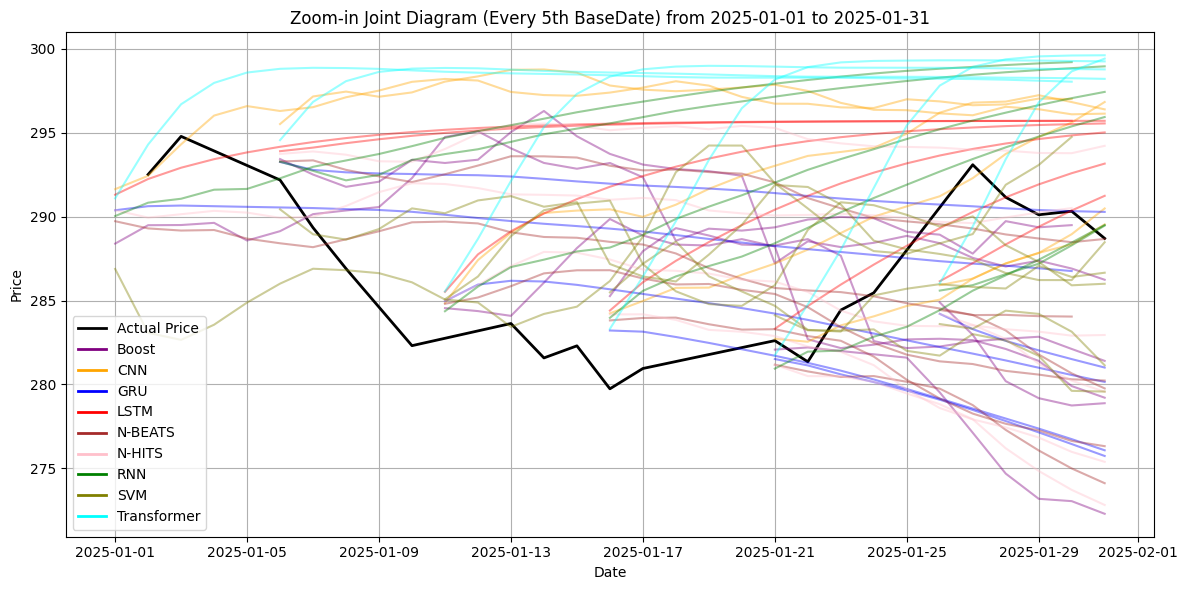


=== 2025-01-02 ===
  Model=CNN, Error=0.081, Conf=1.000
  Model=LSTM, Error=0.270, Conf=0.980
  Model=CNN, Error=0.875, Conf=0.915

=== 2025-01-03 ===
  Model=CNN, Error=0.474, Conf=1.000
  Model=Transformer, Error=0.485, Conf=0.999
  Model=Transformer, Error=0.924, Conf=0.961

=== 2025-01-06 ===
  Model=RNN, Error=0.020, Conf=1.000
  Model=N-HITS, Error=0.067, Conf=0.994
  Model=RNN, Error=0.102, Conf=0.989

=== 2025-01-07 ===
  Model=SVM, Error=0.080, Conf=1.000
  Model=Boost, Error=0.208, Conf=0.986
  Model=SVM, Error=0.393, Conf=0.967

=== 2025-01-08 ===
  Model=SVM, Error=0.006, Conf=1.000
  Model=SVM, Error=0.094, Conf=0.993
  Model=N-BEATS, Error=1.278, Conf=0.894

=== 2025-01-10 ===
  Model=SVM, Error=3.774, Conf=1.000
  Model=SVM, Error=4.320, Conf=0.957
  Model=Boost, Error=4.899, Conf=0.912

=== 2025-01-13 ===
  Model=SVM, Error=0.201, Conf=1.000
  Model=Boost, Error=0.455, Conf=0.983
  Model=RNN, Error=0.731, Conf=0.965

=== 2025-01-14 ===
  Model=Transformer, Error=1.656,

/tmp/ipykernel_646386/1556009569.py:723: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_out = df_merged.groupby("ForecastDate", group_keys=False).apply(compute_confidence_group)
/tmp/ipykernel_646386/1556009569.py:766: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top3["NormConf"] = top3["Confidence"] / sum_conf
/tmp/ipykernel_646386/1556009569.py:766: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib

# Additional imports for sklearn-based models:
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# ============================================
# 1. Set random seeds
# ============================================
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ============================================
# Global hyperparameters
# ============================================
WINDOW_SIZE = 35
NUM_EPOCHS  = 800
features = ["Price", "Open", "High", "Low"]

# Filenames (adjust as needed)
csv_file_train = "McDonald’s Stock Price History.csv"             # Partial / older data
csv_file_complete = "McDonald’s Stock Price History_Complete.csv"  # Full data (incl. future)
best_models_dir = "."  # Directory for saved models (change if needed)

# ============================================
# 2. Load & Clean CSV (Training CSV)
# ============================================
df = pd.read_csv(csv_file_train)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("===== TRAINING CSV INFO =====")
print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

# Train/Val/Test cutoff dates
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-01")  # We'll do day-by-day from Jan 1 to Jan 31

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

# ============================================
# 3. Fit MinMaxScaler on TRAIN only
# ============================================
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

# Optionally, save the scaler if needed
joblib.dump(scaler, "scaler.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================
# 4. Create the training sequences
# ============================================
def make_sequences(df_subset, window=35):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Flatten for sklearn
X_train_flat = X_train_all.reshape((X_train_all.shape[0], WINDOW_SIZE * 4))

# ============================================
# 5. Validation Utilities
# ============================================
def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=35):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]
            true_vals = df_work.loc[idx_current, features]
            true_vals = pd.to_numeric(true_vals, errors="coerce").astype(float).values
            if np.isnan(true_vals).any():
                continue
            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())
    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=35):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_4_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

def iterative_half_blind_validation_preds(model, df_all_scaled, val_start, val_end, window=35):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_idx = df_work.index[df_work["Date"] >= val_start]
    if len(val_idx) == 0:
        raise ValueError("No validation data available after val_start.")
    first_val_idx = val_idx[0]
    
    current_window = df_work.iloc[first_val_idx - window:first_val_idx][features].values
    preds = []
    val_dates = np.sort(df_work[df_work["Date"] >= val_start]["Date"].unique())
    
    model.eval()
    with torch.no_grad():
        for d in val_dates:
            if d > val_end:
                break
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
            
            # Reveal actual for day d
            actual_row = df_work[df_work["Date"] == d][features].values
            if actual_row.shape[0] == 0:
                continue
            actual = actual_row[0]
            current_window = np.vstack((current_window[1:], actual))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# ============================================
# 6. Define the base PyTorch model
# ============================================
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width
        
        if model_type == "CNN":
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)
        elif model_type == "N-BEATS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type in ["LSTM", "GRU", "RNN"]:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1, 0, 2)
            x = self.transformer_encoder(x)
            x = x[-1, :, :]
            out = self.fc(x)
        elif self.model_type in ["N-BEATS", "N-HITS"]:
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

# ============================================
# Early Stopping
# ============================================
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ============================================
# 7. Inverse transform helper
# ============================================
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

# ============================================
# 8. Training function for PyTorch
# ============================================
def train_model(model_type="LSTM", num_epochs=800):
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)
    best_path = os.path.join(best_models_dir, f"best_{model_type}_McDonal_V1.pt")
    
    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"[{model_type}] Loaded existing model from {best_path}")
        return model

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=150)
    early_stopping = EarlyStopping(patience=150)
    
    best_val_loss = float("inf")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        
        val_loss = half_blind_validation_loss(model, df_scaled, val_start=train_cutoff, val_end=val_cutoff, window=WINDOW_SIZE)
        scheduler.step(val_loss)
        early_stopping(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)
        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break
        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")
    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

# ============================================
# 8B. Training function for sklearn
# ============================================
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        x_np = x.cpu().detach().numpy().reshape(1, -1)
        pred = self.model.predict(x_np)  # shape: (1,4)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def train_model_sklearn(model_type, X_train_flat, y_train):
    best_path = os.path.join(best_models_dir, f"best_{model_type}_McDonal_V1.pkl")
    if os.path.exists(best_path):
        model = joblib.load(best_path)
        print(f"[{model_type}] Loaded existing model from {best_path}")
    else:
        if model_type == "SVM":
            base_model = SVR(kernel='rbf', C=10.0, epsilon=0.01)
        elif model_type == "GPR":
            from sklearn.gaussian_process.kernels import RBF
            kernel = RBF(length_scale=1.0)
            base_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
        elif model_type == "Boost":
            base_model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
        else:
            raise ValueError("Unsupported sklearn model type")
        multi_model = MultiOutputRegressor(base_model)
        multi_model.fit(X_train_flat, y_train)
        joblib.dump(multi_model, best_path)
        model = multi_model
    return SklearnWrapper(model)

# ============================================
# 9. Walk-forward test (Original style)
# ============================================
def walk_forward_test(model, df_all_scaled, test_start, window=35):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    preds = []
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled = model(X_input).cpu().numpy()[0]
            df_work.loc[idx_current, features] = y_pred_4_scaled
            preds.append((d, *y_pred_4_scaled))
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# ============================================
# 10. Evaluate & Plot
# ============================================
def evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff):
    df_real = df_scaled[["Date", "Price", "Open", "High", "Low"]].copy()
    df_real.sort_values("Date", inplace=True)
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:, 0]
    
    # Plot 1: Joint diagram
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")
    
    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)

    for model_name, info in results_dict.items():
        val_pred_df = info["val_pred_df"]
        test_pred_df = info["test_pred_df"]
        frames = []
        if val_pred_df is not None:
            frames.append(val_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if test_pred_df is not None:
            frames.append(test_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if not frames:
            continue
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df = combined_df[["Date", f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)
        merged_df = pd.merge(merged_df, combined_df, on="Date", how="left")

    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    for model_name, info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(merged_df["Date"], merged_df[col],
                     color=color_map.get(model_name, "gray"),
                     linestyle="-",
                     label=f"{model_name} Prediction")

    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")
    plt.title("Joint Diagram: Actual Price vs. Model Predictions of McDonald's Stock")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Test Period Zoom-in
    df_test_zoom = merged_df[merged_df["Date"] >= test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        for model_name, info in results_dict.items():
            col = f"Pred_{model_name}"
            if col in df_test_zoom.columns:
                plt.plot(df_test_zoom["Date"], df_test_zoom[col],
                         linestyle="--", label=f"{model_name} Prediction")
        # Load actual test prices from the complete CSV
        df_complete_test = pd.read_csv(csv_file_complete)
        df_complete_test["Date"] = pd.to_datetime(df_complete_test["Date"])
        df_complete_test.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
        df_complete_test.sort_values("Date", inplace=True)
        df_test_actual = df_complete_test[df_complete_test["Date"] >= test_cutoff].copy()
        plt.plot(df_test_actual["Date"], df_test_actual["Price"],
                 color='black', linewidth=2, label='Actual Test Price')

        plt.title("Test Period Zoom-in on McDonald's Stock")
        plt.xlabel("Date")
        plt.ylabel("Price (unscaled)")
        plt.legend(prop={'size':8})
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ============================================
# 11A. Function for Single Joint Diagram (Every 5th BaseDate)
# ============================================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

def plot_joint_5day_forecasts_zoom_in(
    final_rolling_fcst,
    df_actual,
    start_date_plot=pd.to_datetime("2025-01-01"),
    end_date_plot=pd.to_datetime("2025-01-31"),
    base_date_freq=5
):
    """
    Plots a SINGLE figure:
      - The actual price from start_date_plot to end_date_plot
      - Each model's predicted price lines for every 5th 'BaseDate'
      - Each model in a consistent color
    """
    # We'll define a color_map for consistency:
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    # Filter actual prices in [start_date_plot, end_date_plot]
    df_actual_plot = df_actual[
        (df_actual["Date"] >= start_date_plot) & (df_actual["Date"] <= end_date_plot)
    ].copy()

    # Unique base dates in the rolling forecast
    unique_base_dates = sorted(final_rolling_fcst["BaseDate"].unique())
    # We'll keep every 5th base date
    chosen_base_dates = [bd for i, bd in enumerate(unique_base_dates) if i % base_date_freq == 0]

    plt.figure(figsize=(12,6))
    # Plot actual
    plt.plot(df_actual_plot["Date"], df_actual_plot["Price"],
             color="black", linewidth=2, label="Actual Price")

    # For each model, we keep the same color, but multiple lines
    models = final_rolling_fcst["Model"].unique()
    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"] == m].copy()
        c = color_map.get(m, "gray")
        for bd in chosen_base_dates:
            df_bd = df_m[df_m["BaseDate"] == bd].copy()
            # Keep only forecast points in [start_date_plot, end_date_plot]
            df_bd = df_bd[
                (df_bd["ForecastDate"] >= start_date_plot) &
                (df_bd["ForecastDate"] <= end_date_plot)
            ]
            if len(df_bd) < 1:
                continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"],
                     color=c, alpha=0.4, linewidth=1.5)

    # Build custom legend
    legend_elems = [Line2D([0],[0], color="black", lw=2, label="Actual Price")]
    for m in models:
        legend_elems.append(Line2D([0],[0], color=color_map.get(m,"gray"), lw=2, label=m))
    plt.legend(handles=legend_elems, loc="best")

    plt.title(f"Zoom-in Joint Diagram (Every 5th BaseDate) from {start_date_plot.date()} to {end_date_plot.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ============================================
# 11B. Function to compute errors & confidence, print top 3 models
# ============================================
def compute_confidences_and_top3(final_rolling_fcst, df_actual):
    """
    1) Merge final_rolling_fcst with the actual Price on 'ForecastDate'.
    2) Compute absolute error for each (Model, ForecastDate).
    3) For each ForecastDate, normalise to produce a 'Confidence'.
    4) Print top 3 models each day.
    5) Return a DataFrame with columns:
         [ForecastDate, Model, PredPrice, AbsError, Confidence, ActualPrice]
       so we can do mixture-of-experts weighting.
    """
    # Keep the predicted price from final_rolling_fcst
    df_pred = final_rolling_fcst[["ForecastDate", "Model", "Pred_Price_unscaled"]].copy()

    # We rename 'Date' to 'ForecastDate' in the actual df, also rename 'Price' -> 'ActualPrice'
    df_actual_ren = df_actual.rename(columns={"Date": "ForecastDate", "Price": "ActualPrice"})

    # Inner join on ForecastDate => only rows that have an actual price on that day
    df_merged = pd.merge(df_pred, df_actual_ren[["ForecastDate", "ActualPrice"]], on="ForecastDate", how="inner")

    # Drop any NaNs
    df_merged.dropna(subset=["ActualPrice", "Pred_Price_unscaled"], inplace=True)

    # Compute absolute error
    df_merged["AbsError"] = (df_merged["Pred_Price_unscaled"] - df_merged["ActualPrice"]).abs()

    # Group by ForecastDate => assign confidence
    def compute_confidence_group(grp):
        err_min = grp["AbsError"].min()
        err_max = grp["AbsError"].max()
        if abs(err_max - err_min) < 1e-9:
            # all same error => all confidence=1.0
            grp["Confidence"] = 1.0
        else:
            grp["Confidence"] = 1.0 - ((grp["AbsError"] - err_min) / (err_max - err_min))
        return grp

    df_out = df_merged.groupby("ForecastDate", group_keys=False).apply(compute_confidence_group)

    # Print top 3 each day
    unique_days = sorted(df_out["ForecastDate"].unique())
    for d in unique_days:
        day_grp = df_out[df_out["ForecastDate"] == d].copy()
        day_grp.sort_values("AbsError", inplace=True)
        top_n = day_grp.head(3)
        print(f"\n=== {d.date()} ===")
        for _, row in top_n.iterrows():
            print(f"  Model={row['Model']}, Error={row['AbsError']:.3f}, Conf={row['Confidence']:.3f}")

    # We'll return columns for future reference, including predicted price and actual
    df_out = df_out[["ForecastDate", "Model", "Pred_Price_unscaled", "AbsError", "Confidence", "ActualPrice"]].copy()
    return df_out

# ============================================
# 11C. Produce Mixture-of-Experts Forecast
# ============================================
def produce_moe_predictions(df_conf):
    """
    Given the output from compute_confidences_and_top3 (which has columns:
      [ForecastDate, Model, Pred_Price_unscaled, AbsError, Confidence, ActualPrice]),
    for each ForecastDate, select the TOP 3 models by Confidence, renormalize their
    Confidence to sum=1, and produce a final MOE forecast = sum(w_i * pred_i).

    Returns a new DataFrame with columns:
      [ForecastDate, MOE_Pred, ActualPrice, MOE_AbsError, MOE_ConfidenceSum]
    """
    # For each date, pick top 3 by Confidence
    # We can either do .groupby("ForecastDate"), sort by confidence, etc.
    grouped = []
    for fdate, grp in df_conf.groupby("ForecastDate"):
        grp_sorted = grp.sort_values("Confidence", ascending=False).reset_index(drop=True)
        top3 = grp_sorted.head(3)
        sum_conf = top3["Confidence"].sum()
        # If sum_conf=0, fallback or skip
        if abs(sum_conf) < 1e-9:
            # means all zero => weird. Let's just skip or produce average.
            moe_pred = top3["Pred_Price_unscaled"].mean()
            sum_conf = 3.0
        else:
            # Weighted sum
            top3["NormConf"] = top3["Confidence"] / sum_conf
            moe_pred = (top3["NormConf"] * top3["Pred_Price_unscaled"]).sum()

        actual_price = grp["ActualPrice"].iloc[0]  # same for entire group
        moe_abs_err = abs(moe_pred - actual_price)
        # We can store final
        grouped.append({
            "ForecastDate": fdate,
            "MOE_Pred": moe_pred,
            "ActualPrice": actual_price,
            "MOE_AbsError": moe_abs_err,
            "MOE_ConfidenceSum": sum_conf
        })
    df_moe = pd.DataFrame(grouped)
    return df_moe


# ========== End of New/Updated Code from Section 11A onward ==========
#
# Usage in your 'main' flow after you get final_rolling_fcst:
#
#   1) call "df_conf = compute_confidences_and_top3(final_rolling_fcst, df_complete_all)"
#   2) call "df_moe = produce_moe_predictions(df_conf)"
#   3) now "df_moe" has your mixture-of-experts final forecast for each ForecastDate
#      plus the absolute error vs. the actual price.
#
#   4) Optionally, examine or plot df_moe to see how the mixture approach performs.


# A) Plot the combined 5-day base-date forecast lines:
plot_joint_5day_forecasts_zoom_in(
    final_rolling_fcst,
    df_actual=df_complete_all,
    start_date_plot=pd.to_datetime("2025-01-01"),
    end_date_plot=pd.to_datetime("2025-01-31"),
    base_date_freq=5
)

# B) Compute per-model daily confidence
df_conf = compute_confidences_and_top3(final_rolling_fcst, df_complete_all)

# C) Build final mixture-of-experts forecast from top 3 models daily
df_moe = produce_moe_predictions(df_conf)

print("\n===== MOE DataFrame (head) =====")
print(df_moe.head(20))
# Now you can see df_moe['MOE_Pred'] vs. df_moe['ActualPrice'] per ForecastDate
# and check df_moe['MOE_AbsError'] or do more plots
